In [1]:
from util import isotope, read_refdata, \
    symbol_list, symbol_arr,  Z2Symbol, Symbol2Z
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import numpy as np
import pandas as pd
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor as Pool
from concurrent.futures import as_completed

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
import seaborn as sns
from tqdm import tqdm

exp10 = lambda x: np.power(10, x)
log10 = np.log10
import emcee

from bayesian import func_A, func_AB, func_chisqr

In [48]:
obs_logeps = pd.read_csv('J0804_CS30315_logeps.csv')
obs_elogeps = pd.read_csv('J0804_CS30315_elogeps.csv')

nfrac_list = []
nfrac_sols = read_refdata('/home/jiangrz/ssd/GitHub/rproc/data/sne/prantzos2020/s_component.dat')[1]
nfrac_solr = read_refdata('/home/jiangrz/ssd/GitHub/rproc/data/sne/prantzos2020/r_component.dat')[1]
M_sols = np.log10(nfrac_sols)
M_solr = np.log10(nfrac_solr)

nfrac_list = []
P_list = []
for path in Path('/home/jiangrz/ssd/GitHub/rproc/data/sne/nst2017').iterdir():
    if path.suffix == '.dat':
        mfrac, nfrac = read_refdata(path)
        nfrac_list.append(nfrac)
        P_vec = np.array([path.stem[1:]], dtype=np.float64)
        P_list.append(P_vec)
        # break
M_mrsn = np.log10(np.array(nfrac_list))
M_mrsn = M_mrsn - M_mrsn[:, [0]] + 12 # - M[:, [25]]
P_mrsn = np.array(P_list)

nfrac_list = []
P_list = []
for path in Path('/home/jiangrz/ssd/GitHub/rproc/data/sne/hw2010').iterdir():
    if path.suffix == '.dat':
        mfrac, nfrac = read_refdata(path)
        nfrac_list.append(nfrac)
        # break
        P_vec = np.array([path.stem[:4], path.stem[4:7], path.stem[7:]], dtype=np.float64)
        P_vec /= 10
        P_list.append(P_vec)
M_ccsn = np.log10(np.array(nfrac_list))
M_ccsn = M_ccsn - M_ccsn[:, [0]] + 12 # - M[:, [25]]
P_ccsn = np.array(P_list)

nfrac_list = []
P_list = []
for path in Path('/home/jiangrz/ssd/GitHub/rproc/data/sne/just2015').iterdir():
    if path.suffix == '.dat':
        mfrac, nfrac = read_refdata(path)
        nfrac_list.append(nfrac)
        # break
        P_vec = np.array([path.stem[:2], path.stem[2:6], path.stem[6:]], dtype=np.float64)
        # break
        P_vec[1] /= 10000
        P_vec[2] /= 10
        P_list.append(P_vec)
M_nsm = np.log10(np.array(nfrac_list))
M_nsm = M_nsm - M_nsm[:, [0]] + 12 # - M[:, [25]]
P_nsm = np.array(P_list)

nfrac_list = []
P_list = []
for path in Path('/home/jiangrz/ssd/GitHub/rproc/data/sne/bisterzo2010').iterdir():
    if path.suffix == '.dat':
        mfrac, nfrac = read_refdata(path)
        nfrac_list.append(nfrac)
        # break
        P_vec = np.array([path.stem[:2], path.stem[4:-3], path.stem[-2:]], dtype=np.float64)
        # break
        P_vec[0] *= (-.1)
        P_vec[1] *= .1
        P_vec[2] *= .1
        P_list.append(P_vec)
M_agb = np.log10(np.array(nfrac_list))
M_agb = M_agb - M_agb[:, [0]] + 12# - M[:, [25]]
P_agb = np.array(P_list)
M_agb = M_agb[P_agb[:, 0]<=-2.6]
P_agb = P_agb[P_agb[:, 0]<=-2.6]

nfrac_list = []
P_list = []
for path in Path('/home/jiangrz/ssd/GitHub/rproc/data/sne/wu2024').iterdir():
    if path.suffix == '.dat':
        mfrac, nfrac = read_refdata(path)
        nfrac_list.append(nfrac)
        # break
        P_vec = np.array([0], dtype=np.float64)
        P_list.append(P_vec)
M_fsn = np.log10(np.array(nfrac_list))
M_fsn = M_fsn - M_fsn[:, [0]] + 12# - M[:, [25]]
P_fsn = np.array(P_list)

solmfrac, solnfrac = read_refdata('/home/jiangrz/ssd/GitHub/rproc/data/ref/sol_asplund09.dat')
solref = np.log10(solnfrac)
solref = solref - solref[0] + 12

In [50]:
Z_arr = Symbol2Z(symbol_list)
flag_adopt_light = Z_arr <= 30
flag_adopt_mainr = Z_arr > 40
flag_adopt_rs = Z_arr > 30
df_fitparam = pd.DataFrame(
    columns=[
        'starname', 
        'solr', 'sols', 'solrs', 'portion_r', 'portion_s', 'chisqr_rs',
        'progen_mrsn', 'chisqr_mrsn', 'progen_nsm', 'chisqr_nsm', 'progen_fsn', 'chisqr_fsn',
        'progen_mrsn_agb', 'chisqr_mrsn_agb', 'progen_nsm_agb', 'chisqr_nsm_agb', 'progen_fsn_agb', 'chisqr_fsn_agb'])

In [51]:
for star_index in range(len(obs_logeps)):
    starname = obs_logeps.loc[star_index, 'starname']
    O_vec = obs_logeps.iloc[star_index, 1:].values.astype(float)
    eO_vec = obs_elogeps.iloc[star_index, 1:].values.astype(float)

    A, B, chisqr_rs = func_AB(M_solr, M_sols, O_vec, eO_vec, flag_adopt_rs)
    # chisqr_red_sol_rs /= (np.sum(flag_adopt_rs & flag_detect)-1)
    # print(chisqr_red_sol_rs)
    solr = A + M_solr
    sols = B + M_sols
    solrs = np.log10(np.power(10, solr)+np.power(10, sols))
    portion_r = 1/(np.power(10, A)/np.power(10, B)+1)
    portion_s = 1/(np.power(10, B)/np.power(10, A)+1)
    df_fitparam.loc[star_index, :'chisqr_rs'] = [
        starname, 
        solr, sols, solrs, portion_r, portion_s, chisqr_rs]
    
    progen_chisqr = []
    for M_set in [M_mrsn, M_nsm, M_fsn]:
        chisqr_list = []
        flag_adopt = flag_adopt_mainr
        for M_vec in M_set:
            A = func_A(M_vec, O_vec, eO_vec, flag_adopt)
            chisqr = func_chisqr(A, M_vec, O_vec, eO_vec, flag_adopt)
            chisqr_list.append(chisqr)
        chisqr_arr = np.array(chisqr_list)
        progen_ = M_set[np.argmin(chisqr_arr), :].copy()
        chisqr_ = chisqr_arr.min()
        A_set = func_A(progen_, O_vec, eO_vec, flag_adopt)
        progen_ += A_set
        progen_chisqr.extend([progen_, chisqr_])
    df_fitparam.loc[star_index, 'progen_mrsn':'chisqr_fsn'] = progen_chisqr

In [52]:
df_fitparam

,starname,solr,sols,solrs,portion_r,portion_s,chisqr_rs,progen_mrsn,chisqr_mrsn,progen_nsm,chisqr_nsm,progen_fsn,chisqr_fsn,progen_mrsn_agb,chisqr_mrsn_agb,progen_nsm_agb,chisqr_nsm_agb,progen_fsn_agb,chisqr_fsn_agb
0,J0804+5740,"[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -in...","[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -in...","[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -in...",0.243266,0.756734,31.052222,"[1.0521314737297889, 1.3692676945788058, -7.24...",250.082204,"[0.831321410086499, 1.5585896173249338, -8.515...",337.040986,"[-3.485874298066058, 2.191350290899109, -5.940...",1313.08886,NaN,NaN,NaN,NaN,NaN,NaN
1,CS 30315-029,"[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -in...","[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -in...","[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -in...",0.0,1.0,52.141063,"[-0.09790505670942196, 0.21923116413959498, -8...",177.70082,"[-0.40503335721390243, 0.5677732895627603, -7....",247.761521,"[-4.946736981814581, 0.7304876071505859, -7.40...",447.84189,NaN,NaN,NaN,NaN,NaN,NaN


(40.0, 95.0)

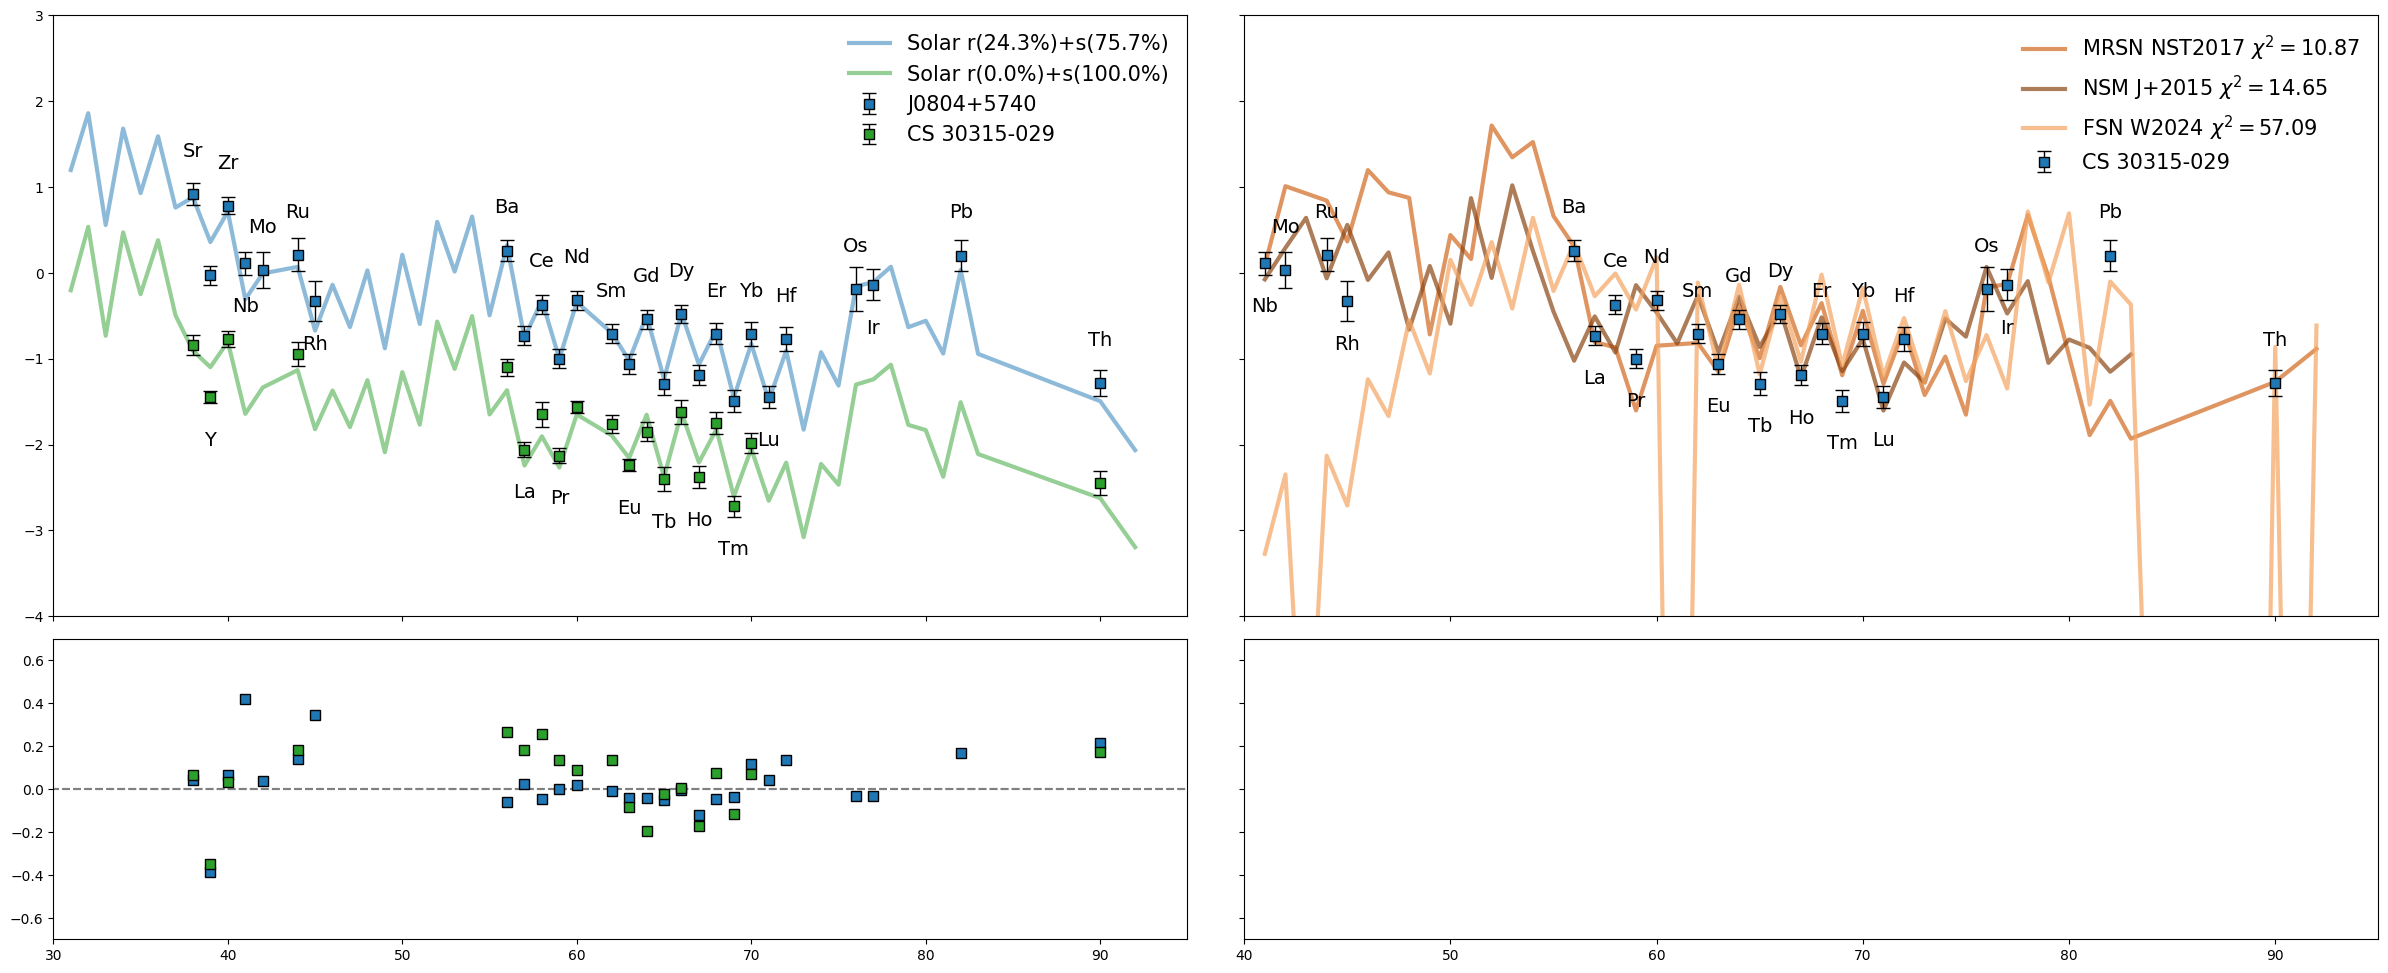

In [58]:
ncols = 2
ec = 'k'
mew = 1
colors = ['C0', 'C2']
progen_color = {
    'progen_mrsn': 'chocolate', 
    'progen_nsm': 'saddlebrown', 
    'progen_fsn': 'sandybrown'
}
progen_label = {
    'progen_mrsn': 'MRSN NST2017', 
    'progen_nsm': 'NSM J+2015', 
    'progen_fsn': 'FSN W2024'
}
fig, axes = plt.subplots(
    2, ncols, figsize=(30, 12), dpi=100, 
    height_ratios=(2, 1), 
    width_ratios=(1, 1), 
    sharex='col', sharey='row')
fig.subplots_adjust(hspace=.05, wspace=.05)
Z_arr = Symbol2Z(symbol_list)
for icol in range(ncols):
    ax, ax_res = axes[:, icol]
    if icol == 0:
        flag_adopt = flag_adopt_rs
        for star_index in range(len(obs_logeps)):
            O_vec = obs_logeps.iloc[star_index, 1:].values.astype(float)
            eO_vec = obs_elogeps.iloc[star_index, 1:].values.astype(float)
            starname, \
                solr, sols, solrs, \
                portion_r, portion_s = df_fitparam.iloc[star_index, :6]
            ax.errorbar(
                Z_arr[flag_adopt], O_vec[flag_adopt], yerr=eO_vec[flag_adopt],
                ecolor=ec, elinewidth=mew, linestyle='', capsize=5, capthick=3,
                marker='s', markersize=7, mfc=colors[star_index], mec=ec, mew=mew,
                alpha=1, label=starname, zorder=10)
            ax.plot(
                Z_arr[np.isfinite(solrs)&flag_adopt], 
                solrs[np.isfinite(solrs)&flag_adopt], 
                linewidth=3, c=colors[star_index], alpha=.5, 
                label='Solar r(%.1f%%)+s(%.1f%%)'%(portion_r*100, portion_s*100), 
                zorder=2)
            ax_res.errorbar(
                Z_arr[flag_adopt], (O_vec-solrs)[flag_adopt], #yerr=eO_vec[flag_adopt_rs],
                ecolor=ec, elinewidth=mew, linestyle='', capsize=5, capthick=3,
                marker='s', markersize=7, mfc=colors[star_index], mec=ec, mew=mew,
                label=starname, 
                alpha=1, zorder=10)
            ax_res.hlines(0, 28, 95, colors='gray', linestyles='dashed')
            ax_res.set_ylim(-0.7, .7)
            ax.legend(loc='best', fontsize=15, frameon=False)
        O_mat = obs_logeps.iloc[:, 1:].values.astype(float)
        sign_odd = np.sign(.5 - Z_arr % 2)
        text_y = sign_odd * np.nanmax(sign_odd * O_mat, axis=0)
        for _x, _y, _t, _s in zip(Z_arr, text_y, symbol_arr, sign_odd):
            if flag_adopt[Symbol2Z(_t)-1]:
                if np.isnan(_y):
                    continue
                ax.text(_x, _y+.5*_s, _t, ha='center', va='center', fontsize=14, zorder=5)
    elif icol == 1:
        star_index = 0
        flag_adopt = flag_adopt_mainr
        O_vec = obs_logeps.iloc[star_index, 1:].values.astype(float)
        eO_vec = obs_elogeps.iloc[star_index, 1:].values.astype(float)
        ax.errorbar(
            Z_arr[flag_adopt], O_vec[flag_adopt], yerr=eO_vec[flag_adopt],
            ecolor=ec, elinewidth=mew, linestyle='', capsize=5, capthick=3,
            marker='s', markersize=7, mfc=colors[star_index], mec=ec, mew=mew,
            alpha=1, label=starname, zorder=10)
        for progen_key in ['progen_mrsn', 'progen_nsm', 'progen_fsn']:
            progen_ = df_fitparam.loc[star_index, progen_key]
            chisqr_ = df_fitparam.loc[star_index, progen_key.replace('progen', 'chisqr')]
            ax.plot(
                Z_arr[np.isfinite(progen_)&flag_adopt], 
                progen_[np.isfinite(progen_)&flag_adopt], 
                linewidth=3, c=progen_color[progen_key], alpha=.7, 
                label=progen_label[progen_key]+r'$\ \chi^2=%.2f$'%(chisqr_/(np.sum(~np.isnan(O_vec[flag_adopt]))-1)), 
                zorder=2)
        sign_odd = np.sign(.5 - Z_arr % 2)
        for _x, _y, _t, _s in zip(Z_arr, O_vec, symbol_arr, sign_odd):
            if flag_adopt[Symbol2Z(_t)-1]:
                if np.isnan(_y):
                    continue
                ax.text(_x, _y+.5*_s, _t, ha='center', va='center', fontsize=14, zorder=5)

        ax.legend(loc='best', fontsize=15, frameon=False)
axes[0, 0].set_ylim(-4, 3)
axes[0, 0].set_xlim(30, 95)
axes[0, 1].set_xlim(40, 95)

## Multi-component

In [5]:
M_B = M_agb
progen_chisqr = []
for M_A in [M_mrsn, M_nsm, M_fsn]:
    with Pool(max_workers=30) as pool, tqdm(total=len(M_A)*len(M_B)) as pbar:
        chisqr_arr = np.full((len(M_A), len(M_B)), np.inf)
        A_arr = np.full((len(M_A), len(M_B)), np.inf)
        B_arr = np.full((len(M_A), len(M_B)), np.inf)
        futures = {}
        for idx_0, M_vec_0 in enumerate(M_A):
            for idx_1, M_vec_1 in enumerate(M_B):
                future = pool.submit(
                    func_AB, 
                    M_vec_0, M_vec_1, O_vec, eO_vec, flag_adopt_rs)
                future.add_done_callback(lambda p: pbar.update())
                futures.update({'%03d_%02d'%(idx_0, idx_1): future})
        
        for key in futures:
            idx_0, idx_1 = key.split('_')
            idx_0 = int(idx_0)
            idx_1 = int(idx_1)
            A, B, chisqr = futures[key].result()
            A_arr[idx_0, idx_1] = A
            B_arr[idx_0, idx_1] = B
            chisqr_arr[idx_0, idx_1] = chisqr
        arg_min = np.unravel_index(np.argmin(chisqr_arr, axis=None), chisqr_arr.shape)
        A = A_arr[arg_min]
        B = B_arr[arg_min]
        progen_ = np.log10(np.power(10, A+M_A[arg_min[0]])+np.power(10, B+M_B[arg_min[1]]))
        chisqr_ = chisqr_arr.min()
        progen_chisqr.extend([progen_, chisqr_])
df_fitparam.loc[star_index, 'progen_mrsn_agb':'chisqr_fsn_agb'] = progen_chisqr

100%|██████████| 72/72 [00:14<00:00,  5.12it/s]


In [62]:
# df_fitparam.to_csv('fitparam.csv', index=False)

(30.0, 95.0)

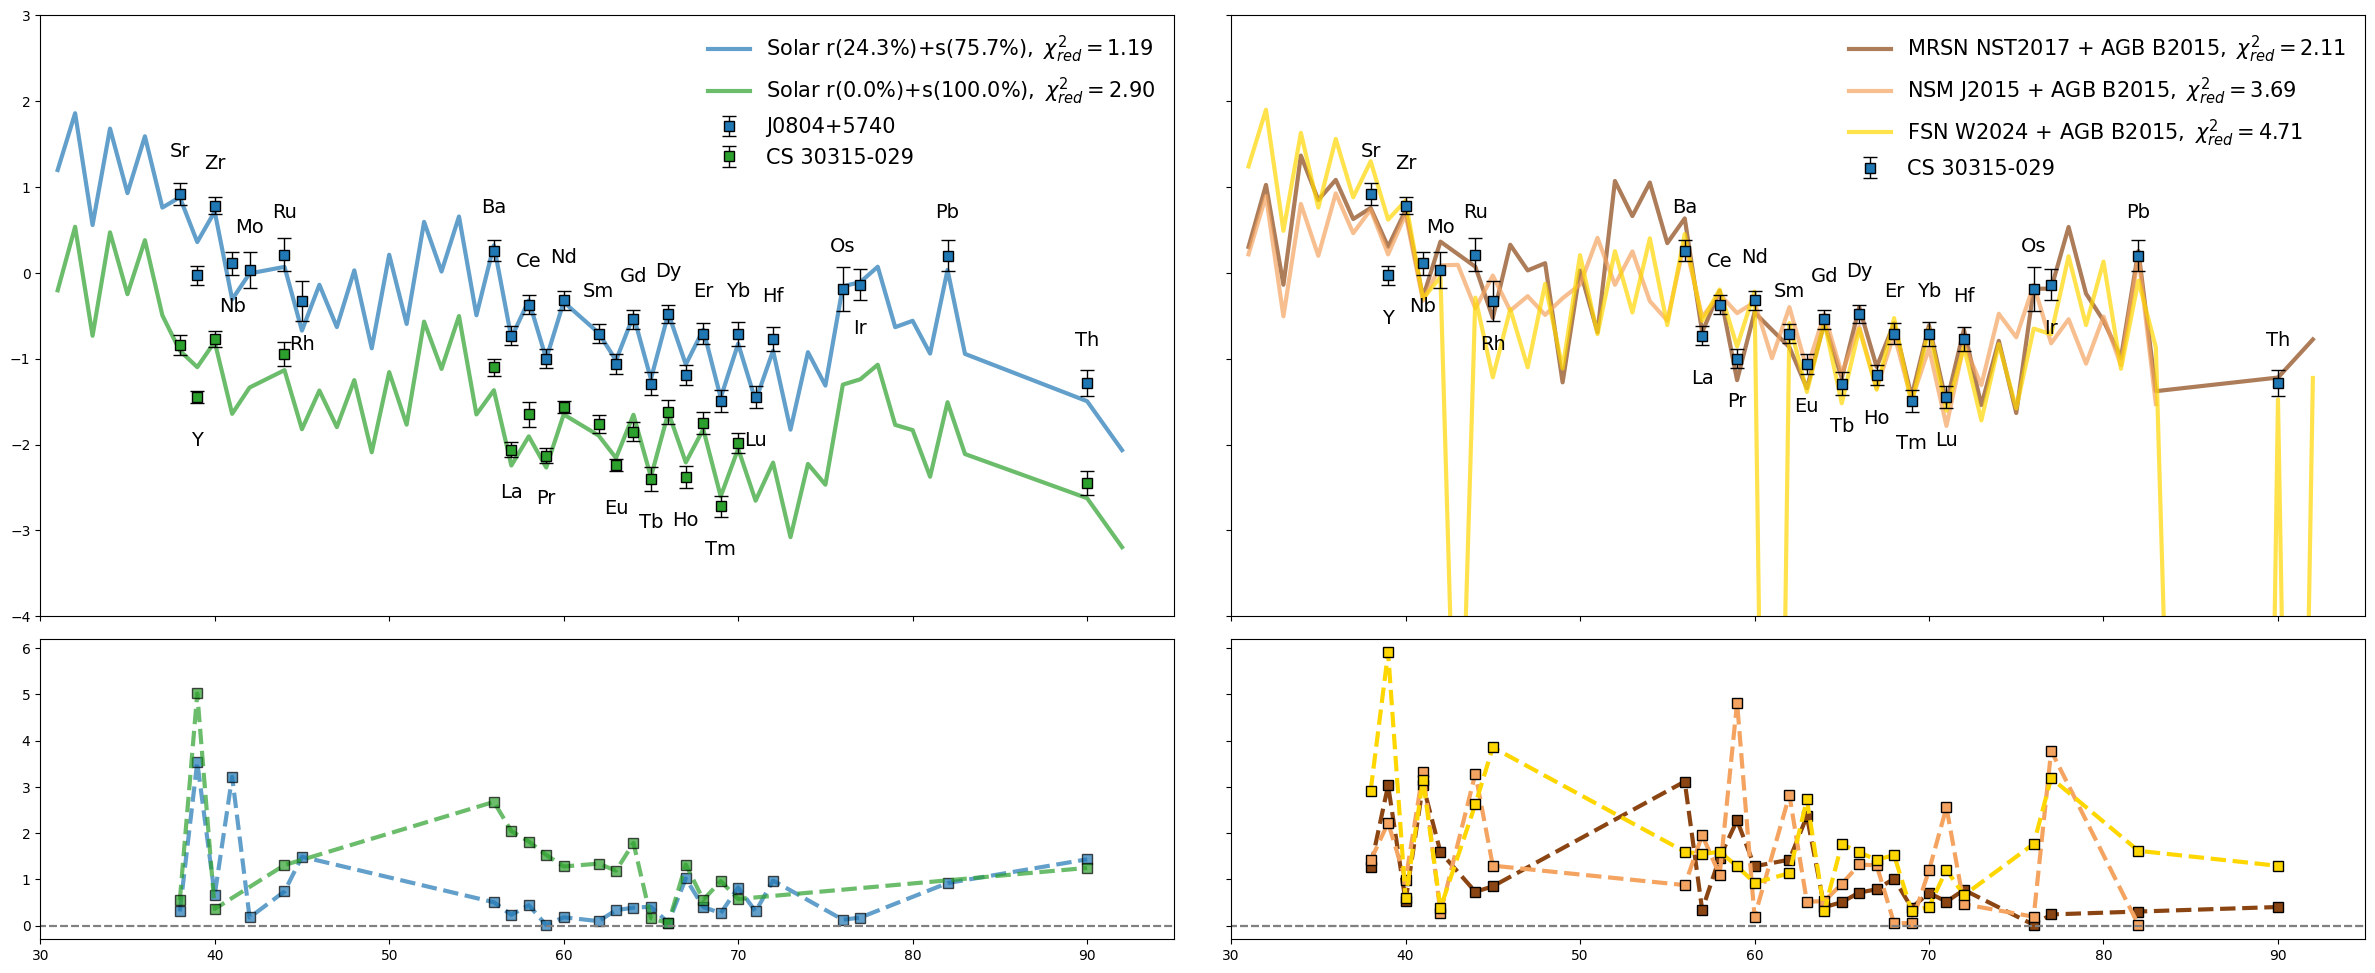

In [69]:
ncols = 2
ec = 'k'
mew = 1
colors = ['C0', 'C2']
progen_color = {
    'progen_mrsn_agb': 'saddlebrown', 
    'progen_nsm_agb': 'sandybrown', 
    'progen_fsn_agb': 'gold'
}
progen_label = {
    'progen_mrsn_agb': 'MRSN NST2017 + AGB B2015', 
    'progen_nsm_agb': 'NSM J2015 + AGB B2015', 
    'progen_fsn_agb': 'FSN W2024 + AGB B2015'
}
fig, axes = plt.subplots(
    2, ncols, figsize=(30, 12), dpi=100, 
    height_ratios=(2, 1), 
    width_ratios=(1, 1), 
    sharex='col', sharey='row')
fig.subplots_adjust(hspace=.05, wspace=.05)
Z_arr = Symbol2Z(symbol_list)
for icol in range(ncols):
    ax, ax_res = axes[:, icol]
    if icol == 0:
        flag_adopt = flag_adopt_rs
        for star_index in range(len(obs_logeps)):
            O_vec = obs_logeps.iloc[star_index, 1:].values.astype(float)
            eO_vec = obs_elogeps.iloc[star_index, 1:].values.astype(float)
            starname, \
                solr, sols, solrs, \
                portion_r, portion_s, chisqr_ = df_fitparam.iloc[star_index, :7]
            ax.errorbar(
                Z_arr[flag_adopt], O_vec[flag_adopt], yerr=eO_vec[flag_adopt],
                ecolor=ec, elinewidth=mew, linestyle='', capsize=5, capthick=3,
                marker='s', markersize=7, mfc=colors[star_index], mec=ec, mew=mew,
                alpha=1, label=starname, zorder=10)
            ax.plot(
                Z_arr[np.isfinite(solrs)&flag_adopt], 
                solrs[np.isfinite(solrs)&flag_adopt], 
                linewidth=3, c=colors[star_index], alpha=.7, 
                label='Solar r(%.1f%%)+s(%.1f%%)'%(portion_r*100, portion_s*100)+r'$,\ \chi^2_{red}=%.2f$'%(chisqr_/(np.sum(~np.isnan(O_vec[flag_adopt]))-1)), 
                zorder=2)
            ax_res.plot(
                Z_arr[np.isfinite(O_vec)&np.isfinite(solrs)&flag_adopt], 
                np.abs((O_vec-solrs)/eO_vec)[np.isfinite(O_vec)&np.isfinite(solrs)&flag_adopt], 
                linestyle='--', linewidth=3, c=colors[star_index], alpha=.7, 
                marker='s', markersize=7, mfc=colors[star_index], mec=ec, mew=mew,
                zorder=2)
            # ax_res.errorbar(
            #     Z_arr[flag_adopt], (O_vec-solrs)[flag_adopt], #yerr=eO_vec[flag_adopt_rs],
            #     ecolor=ec, elinewidth=mew, linestyle='--', capsize=5, capthick=3,
            #     marker='s', markersize=7, mfc=colors[star_index], mec=ec, mew=mew,
            #     label=starname, 
            #     alpha=1, zorder=10)
            ax_res.hlines(0, 28, 95, colors='gray', linestyles='dashed')
            ax.legend(loc='best', fontsize=15, frameon=False)
        O_mat = obs_logeps.iloc[:, 1:].values.astype(float)
        sign_odd = np.sign(.5 - Z_arr % 2)
        text_y = sign_odd * np.nanmax(sign_odd * O_mat, axis=0)
        for _x, _y, _t, _s in zip(Z_arr, text_y, symbol_arr, sign_odd):
            if flag_adopt[Symbol2Z(_t)-1]:
                if np.isnan(_y):
                    continue
                ax.text(_x, _y+.5*_s, _t, ha='center', va='center', fontsize=14, zorder=5)
    elif icol == 1:
        star_index = 0
        flag_adopt = flag_adopt_rs
        O_vec = obs_logeps.iloc[star_index, 1:].values.astype(float)
        eO_vec = obs_elogeps.iloc[star_index, 1:].values.astype(float)
        ax.errorbar(
            Z_arr[flag_adopt], O_vec[flag_adopt], yerr=eO_vec[flag_adopt],
            ecolor=ec, elinewidth=mew, linestyle='', capsize=5, capthick=3,
            marker='s', markersize=7, mfc=colors[star_index], mec=ec, mew=mew,
            alpha=1, label=starname, zorder=10)
        for progen_key in progen_color.keys():
            progen_ = df_fitparam.loc[star_index, progen_key]
            chisqr_ = df_fitparam.loc[star_index, progen_key.replace('progen', 'chisqr')]
            ax.plot(
                Z_arr[np.isfinite(progen_)&flag_adopt], 
                progen_[np.isfinite(progen_)&flag_adopt], 
                linewidth=3, c=progen_color[progen_key], alpha=.7, 
                label=progen_label[progen_key]+r'$,\ \chi^2_{red}=%.2f$'%(chisqr_/(np.sum(~np.isnan(O_vec[flag_adopt]))-1)), 
                zorder=2)
            ax_res.plot(
                Z_arr[np.isfinite(O_vec)&np.isfinite(solrs)&flag_adopt], 
                np.abs((O_vec-progen_)/eO_vec)[np.isfinite(O_vec)&np.isfinite(solrs)&flag_adopt], 
                linestyle='--', linewidth=3, c=progen_color[progen_key],
                marker='s', markersize=7, mfc=progen_color[progen_key], mec=ec, mew=mew,
                zorder=2)
            ax_res.hlines(0, 28, 95, colors='gray', linestyles='dashed')
        sign_odd = np.sign(.5 - Z_arr % 2)
        for _x, _y, _t, _s in zip(Z_arr, O_vec, symbol_arr, sign_odd):
            if flag_adopt[Symbol2Z(_t)-1]:
                if np.isnan(_y):
                    continue
                ax.text(_x, _y+.5*_s, _t, ha='center', va='center', fontsize=14, zorder=5)

        ax.legend(loc='best', fontsize=15, frameon=False)
axes[0, 0].set_ylim(-4, 3)
# axes[1, 0].set_ylim(-.1, 1)
axes[0, 0].set_xlim(30, 95)
axes[0, 1].set_xlim(30, 95)